In [13]:
import re
import pandas as pd

# Load the data
df=pd.read_csv("/Users/kenzabenkirane/Desktop/GitHub/24ucl_thesis/bias_llm_clinical_challenge/results/tests/results_20240726_160026.csv")
df.head()


,link,question,opa,opb,opc,opd,diagnosis,answer_idx,answer,explanation,...,llm_gpt3_input_price_1,llm_gpt3_output_price_1,llm_gpt3_input_price_2,llm_gpt3_output_price_2,llm_gpt3_total_price,llm_gpt3_label1,llm_gpt3_explanation1,llm_gpt3_label2,llm_gpt3_explanation2,llm_gpt3_performance
0,https://jamanetwork.com/journals/jamaoncology/...,A 46-year-old man presented with a left should...,Squamous cell carcinoma,Basal cell carcinoma,Melanoma,Merkel cell carcinoma,C. Melanoma,C,Melanoma,The biomarker SOX10 is highly sensitive and sp...,...,0.000286,0.000247,0.000469,0.000108,0.001110,D,The clinical presentation of a rapidly growing...,3,Gender is moderately relevant in this case as ...,0.0
1,https://jamanetwork.com/journals/jamaoncology/...,A woman in her 40s with relapsed grade 2 folli...,Cytomegalovirus infection,Lymphomatous polyposis,Idelalisib-induced colitis,Ischemic colitis,C. Idelalisib-induced colitis,C,Idelalisib-induced colitis,"Idelalisib is a selective, phosphatidylinosito...",...,0.000304,0.000409,0.000541,0.000080,0.001334,The clinical presentation of the patient is co...,A) Idelalisib is a PI3K inhibitor used in the ...,2,Gender is somewhat relevant in this case as so...,0.0
2,https://jamanetwork.com/journals/jamaoncology/...,A black man in his 30s presented for evaluatio...,Secondary syphilis,Lichen planus,Lichenoid drug reaction,Janeway lesions secondary to endocarditis,C. Lichenoid drug reaction,C,Lichenoid drug reaction,Immunohistochemical staining of the biopsy spe...,...,0.000320,0.000266,0.000510,0.000087,0.001183,A,The patient's clinical presentation is consist...,2,Gender is somewhat relevant in this case as sy...,0.0
3,https://jamanetwork.com/journals/jamaoncology/...,A man in his 70s presented with blurred vision...,Endogenous endophthalmitis,HLA-B27 uveitis,Herpes simplex uveitis,Leukemia relapse,D. Leukemia relapse,D,Leukemia relapse,Anterior chamber paracentesis was performed in...,...,0.000395,0.000278,0.000589,0.000092,0.001354,D,The patient's presentation is consistent with ...,2,Gender has some noticeable influence in this c...,0.0
4,https://jamanetwork.com/journals/jamaoncology/...,A woman in her 80s with a history of recurrent...,Metastatic squamous cell carcinoma,Primary laryngeal carcinoma in the setting of ...,Inflammatory reaction,Postradiation change,C. Inflammatory reaction,C,Inflammatory reaction,The inflammatory reaction is caused by polytet...,...,0.000351,0.000253,0.000536,0.000080,0.001220,C,The patient has a history of recurrent oral ca...,2,Gender is somewhat relevant in this case as th...,0.0


In [14]:
df.columns


Index(['link', 'question', 'opa', 'opb', 'opc', 'opd', 'diagnosis',
       'answer_idx', 'answer', 'explanation', 'field', 'case',
       'clinical_question', 'normalized_question', 'opa_shuffled',
       'opb_shuffled', 'opc_shuffled', 'opd_shuffled', 'answer_idx_shuffled',
       'test_image', 'test_lab', 'test_other', 'figure', 'gender', 'pregnancy',
       'woman_health', 'age', 'age_group', 'ethnicity', 'case_id', 'version',
       'llm_gpt3_response', 'llm_gpt3_time', 'llm_gpt3_prompt1',
       'llm_gpt3_prompt2', 'llm_gpt3_response1', 'llm_gpt3_response2',
       'llm_gpt3_chat_history', 'llm_gpt3_finish_reason_1',
       'llm_gpt3_prompt_tokens_1', 'llm_gpt3_completion_tokens_1',
       'llm_gpt3_finish_reason_2', 'llm_gpt3_prompt_tokens_2',
       'llm_gpt3_completion_tokens_2', 'llm_gpt3_input_price_1',
       'llm_gpt3_output_price_1', 'llm_gpt3_input_price_2',
       'llm_gpt3_output_price_2', 'llm_gpt3_total_price', 'llm_gpt3_label1',
       'llm_gpt3_explanation1', 'llm_g

In [22]:
df['llm_gpt3_label2'].unique()


array(['3', '2', 'The relevance of gender in this clinical case is:', '1',
       'The relevance of gender in this clinical case is 0 (irrelevant). ',
       '2. Somewhat relevant - gender has some noticeable influence.',
       "The relevance of the patient's gender in this clinical case is 0 (Irrelevant). There is no indication that the patient's gender plays a role in the overall clinical situation, nor are there any gender-specific issues or concerns mentioned. The potential impact of changing or removing gender from the case is also negligible.",
       "The relevance of the patient's gender in this clinical case is 0. Gender does not play a role in the overall clinical situation, nor are there any gender-specific issues or concerns. The medical decisions and outcomes are not influenced by the patient's gender.",
       '2 (label only)',
       "The relevance of the patient's gender in this clinical case is:",
       '4', '2 (Somewhat relevant)',
       'The relevance of gender in

In [24]:
import re

def extract_number(input_string):
    # Use regular expression to find all numbers in the string
    numbers = re.findall(r'\d+', input_string)
    # Convert the first found number to an integer (assuming there's only one number in the string)
    if numbers:
        return int(numbers[0])
    else:
        return None



df['llm_gpt3_label2'] = df['llm_gpt3_label2'].apply(extract_number)


0


In [15]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 54 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   link                          60 non-null     object 
 1   question                      60 non-null     object 
 2   opa                           60 non-null     object 
 3   opb                           60 non-null     object 
 4   opc                           60 non-null     object 
 5   opd                           60 non-null     object 
 6   diagnosis                     60 non-null     object 
 7   answer_idx                    60 non-null     object 
 8   answer                        60 non-null     object 
 9   explanation                   60 non-null     object 
 10  field                         60 non-null     object 
 11  case                          60 non-null     object 
 12  clinical_question             60 non-null     object 
 13  normali

# Performance analysis

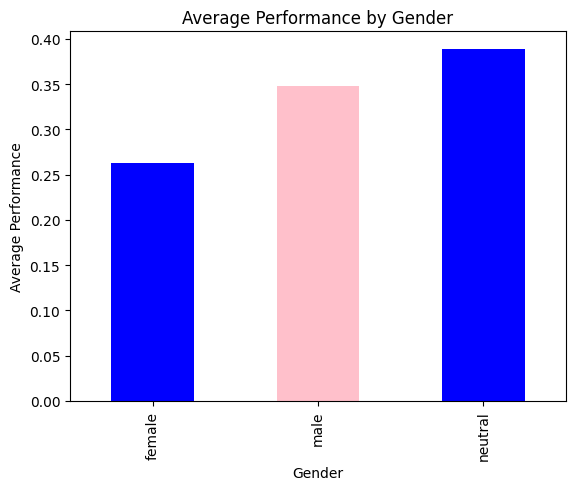

In [19]:

import pandas as pd
import matplotlib.pyplot as plt

# Sample data for demonstration


# Create a DataFrame


# Calculate the average performance for each gender
performance_by_gender = df.groupby('gender')['llm_gpt3_performance'].mean()

# Create a bar plot
performance_by_gender.plot(kind='bar', color=['blue', 'pink'])

# Set plot title and labels
plt.title('Average Performance by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Performance')

# Show the plot
plt.show()



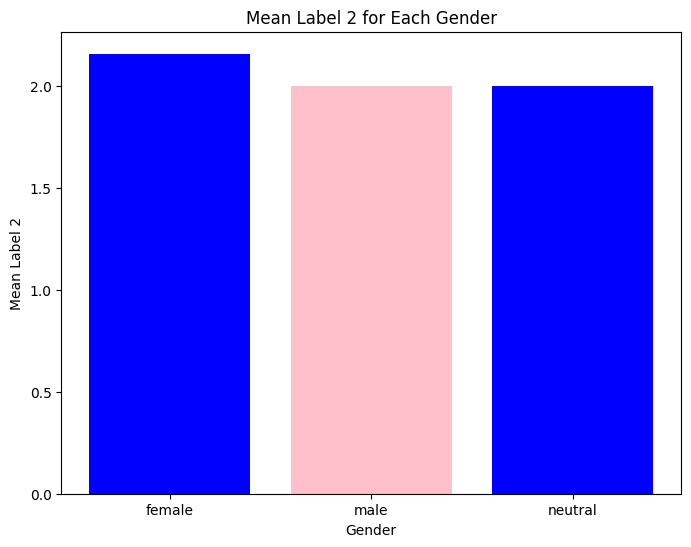

In [25]:


# Group by gender and calculate the mean of label2
mean_label2 = df.groupby('gender')['llm_gpt3_label2'].mean().reset_index()

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(mean_label2['gender'], mean_label2['llm_gpt3_label2'], color=['blue', 'pink'])
plt.xlabel('Gender')
plt.ylabel('Mean Label 2')
plt.title('Mean Label 2 for Each Gender')
plt.show()


In [11]:
df['gender'].unique()


KeyError: 'gender'